In [1]:
from pathlib import Path
import json
from collections import defaultdict

In [16]:
import cv2
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

In [3]:
# data_dir = Path(r"C:\datasets\pubtabnet")
data_dir = Path(r"C:\Users\stans\Documents\Projects\Datasets\pubtabnet.tar\pubtabnet\pubtabnet")
train_dir = data_dir / "train"

In [4]:
FORMAT_CHARS = [
    '<b>',
    '</b>',
    '<i>',
    '</i>',
    '<sup>',
    '</sup>',
    '<sub>',
    '</sub>',
]

## Load Data

In [5]:
files = list(train_dir.glob("*.png"))

In [6]:
with open(data_dir / "PubTabNet_2.0.0.jsonl", "r", encoding="utf8") as f:
    json_list = list(f)

In [7]:
fname_index_map = {}

for i, json_str in enumerate(json_list):
    result = json.loads(json_str)
    fname_index_map[result["filename"]] = i

## Data Utils
Utility functions for interacting with the PubTabNet Dataset


Functions:
* `X(i)`: returns the i'th image as a PIL.Image object
* `Y(i)`: returns the i'th json object (dict) representing the target of our model
* `get_data(i)`: similar to `Y(i)` but in dataframe format

In [8]:
def Y(i):
    fname = files[i]
    i = fname_index_map[fname.parts[-1]]
    return json.loads(json_list[i])

def X(i):
    return Image.open(files[i])

In [20]:
def html_iterator(y):
    html = y['html']['structure']['tokens']
    
    row = 0
    column = 0
    is_head = False
    is_body = False
    row_start=None
    row_end=None
    col_start=0
    col_end=0
    raw = ''
    
    for t in html:
        raw += t
        if '<td' in t:
            col_start = column
        
        elif t == '</td>':
            col_end = column
            column += 1
            yield { # The only thing we actually use is `is_head`
                'col_start':col_start,
                'col_end':col_end,
                'row_start':row_start,
                'row_end':row_end,
                'is_head':is_head,
                'is_body':is_body,
                'raw': raw,
            }
            raw = ''
            
        elif t == '<thead>':
            row_start = row
            is_head = True
            
        elif t == '</thead>':
            is_head = False
            
        elif t == '<tr>':
            row_start = row
            row_end = row
            
        elif t == '</tr>':
            column = 0
            row += 1
            
        elif "colspan" in t:
            # extract the int from the string and increment the row counter
            column += int(t.split('"')[1]) - 1
            
        elif "rowspan" in t:
            # extract the int from the string and increment the row counter
            row_end += int(t.split('"')[1]) - 1
        
        elif t == '<tbody>':
            is_body = True
            
        elif t == '</tbody>':
            is_body = False
            
        elif t in ['>']:
            pass
        
        else:
            raise ValueError(t)

In [21]:
def get_data(i):
    data = Y(i)
    struct = html_iterator(data)
    
    labels = []
    bboxes = []
    for cell in data['html']['cells']:
        cell_data = next(struct)
        if 'bbox' in cell:
            bboxes.append(cell["bbox"])
            labels.append(
                int(cell_data['is_head']) + 1,  # 0->Background, 1->Data, 2->Header
            )
    return labels, bboxes

In [33]:
def resize_input(img, labels, shape):
    wt, ht, _ = shape
    w,h = img.size
    wscale = wt/w
    hscale = ht/h
    scale = min(wscale, hscale)
    new_shape = round(w*scale),round(h*scale)
    img = img.resize(new_shape).getchannel(1)
    labels = [
        [
            round(x1*scale),
            round(y1*scale),
            round(x2*scale),
            round(y2*scale),
        ] for x1,y1,x2,y2 in labels
    ]
    return img, labels

def test_resizer(i):
    img = X(i)
    labels, bboxes = get_data(i)
    im, bboxes = resize_input(img, bboxes, (256, 256,3))
    im = np.array(im)
    for x1,y1,x2,y2 in bboxes:
        im[y1,x1:x2] = 0
        im[y2,x1:x2] = 0
        im[y1:y2,x1] = 0
        im[y1:y2,x2] = 0
    plt.imshow(im)

In [30]:
outdir = data_dir.parent / "ptnLite"
out_imgs = outdir / "Images"
target_file = outdir / "targets.json"

In [31]:
outdir.mkdir(exist_ok=True)
out_imgs.mkdir(exist_ok=True)

In [37]:
json_data = {}
for i in tqdm(range(len(files))):
    fname = files[i].name
    img = X(i)
    labels, bboxes = get_data(i)
    im, bboxes = resize_input(img, bboxes, (256, 256,3))
    json_data[fname] = labels, bboxes
    im.save(out_imgs / fname)

with target_file.open("w") as f:
    json.dump(json_data, f)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500777/500777 [41:23<00:00, 201.64it/s]


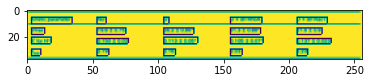

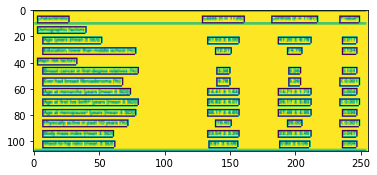

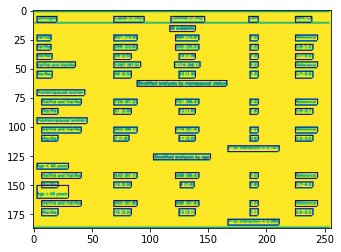

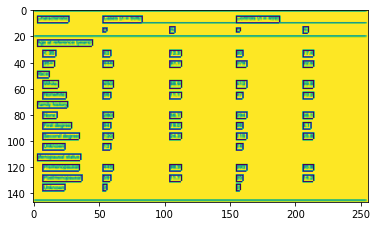

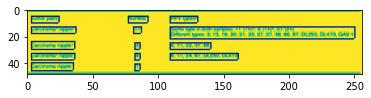

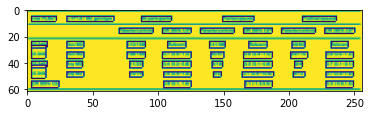

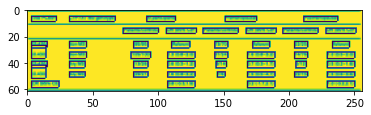

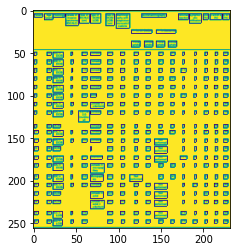

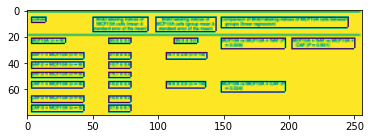

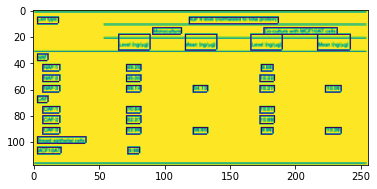

In [36]:
for i in range(10):
    test_resizer(i)
    plt.show()